In [461]:
import networkx
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [462]:
data = pd.read_csv("../data_raw/gene_summary.tsv", sep="\t")

In [463]:
genes = data.id.values

In [464]:
G = networkx.read_edgelist(
      "../data_raw/mouse_gene_network.tsv",
      delimiter="\t",
      data=(('weight', float),),
      nodetype=str)

In [465]:
essential_genes = np.array(list(genes[:4]) + ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"])

In [466]:
neighbors = []
for c in essential_genes:
     neighbors += networkx.neighbors(G, c)
neighbors = np.unique(neighbors)

In [467]:
G = G.subgraph(np.sort(neighbors))

In [468]:
np.random.seed(42)
nonessential_genes = np.random.choice(list(G.nodes), size=30, replace=False)
filter_genes = np.append(essential_genes, nonessential_genes)

In [469]:
G_filtered = G.subgraph(np.sort(filter_genes))

In [470]:
essential_gene_map = {e: e for i, e in enumerate(list(G_filtered.nodes)) if e in essential_genes}

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


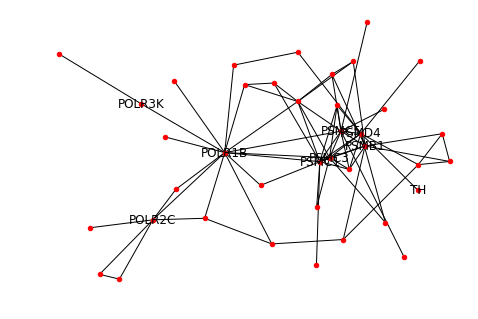

In [471]:
networkx.draw(G_filtered, node_size=20, labels=essential_gene_map);

In [472]:
cliques = [len(c) for c in networkx.clique.find_cliques(G_filtered)]

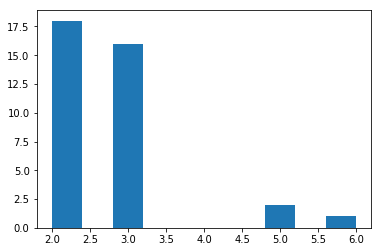

In [473]:
plt.hist(cliques);

## Data generation

In [474]:
np.random.seed(1)

In [475]:
tau = .5

In [476]:
n_essential = len(essential_genes)
n_nonessential = len(nonessential_genes)
n_genes = n_essential + n_nonessential

gamma_essential = sp.random.normal(-1, tau, size=n_essential)
gamma_nonessential = sp.random.normal(0, tau, size=n_nonessential)
gamma = sp.append(gamma_essential, gamma_nonessential)

In [477]:
n_conditions, n_sgrnas, n_replicates = 4, 5, 5

In [478]:
conditions = ["C" + str(i) for i in range(n_conditions)]
genes = filter_genes
sgrnas = ["S" + str(i) for i in range(n_sgrnas)]
replicates = ["R" + str(i) for i in range(n_replicates)]

In [479]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [480]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [481]:
sgrna_ids = np.repeat(["S" + str(i) \
                       for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.sgrnas = sgrna_ids

In [482]:
condition_ids = np.repeat(["C" + str(i) \
                           for i in range(n_genes * n_conditions)],
                          n_sgrnas * n_replicates)
count_table.conditions = condition_ids

In [483]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [484]:
beta = st.norm.rvs(np.repeat(gamma, n_conditions), tau)
l = st.norm.rvs(0, tau, size = n_conditions * n_genes * n_sgrnas)

In [485]:
data = st.norm.rvs(
    l[count_table["sgrnas"]] + 
    beta[count_table["conditions"]],
    tau
)

In [496]:
count_table = pd.DataFrame(
    combinations, 
    columns=["gene", "condition", "intervention", "replicates"])
count_table["readout"] = data
sgrna_ids = np.repeat(["S" + str(i) for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.intervention = sgrna_ids

In [500]:
count_table.to_csv("../data_raw/simulated_data.tsv", index=False, sep="\t")